In [1]:
import utils
import models
import executor
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import pandas as pd
from utils import perfect_square_acc
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# load your data here if kodaira symbol has been processed
# the data file has its Kodaira symbols already preprocessed 
path = Path("..") / "data_files" / "sha"/ "ecq_sha_B_100_conds_1_500000_reg.parquet"
df = utils.load_data(path)
# BSD Features
df_BSD = df[['rank', 'special_value', 'torsion', 'regulator', 'real_period', 'tamagawa_product','sha']]

Loaded the dataset with 120 features and 3064705 curves..


In [3]:
# to get a balanced dataset with equal amount of 1 and 4 labels
len_4 = df_BSD[df_BSD['sha'] == 4].shape[0]
df_BSD_balanced = df_BSD[df_BSD['sha'] == 1].sample(len_4) 
# df_BSD_balanced = df_BSD[df_BSD['sha'] == 1].iloc[:len_4]
df_BSD_balanced = pd.concat([df_BSD_balanced, df_BSD[df_BSD['sha'] == 4]])
df_BSD_balanced.sha.value_counts()

1    158758
4    158758
Name: sha, dtype: int64

In [4]:
# choose model parameters
hidden_units = [128,64,32]

# default model parameters
input_dim, output_dim = utils.get_input_output_dim(df_BSD_balanced, 'sha', if_regression=True)

# check if we have cuda available
device = utils.get_device()

# create model
model = models.VanillaNN(input_dim, hidden_units, output_dim, if_dropout=False, dropout_rate=0.3, if_batchnorm=True).to(device)
# model = models.VanillaNN(input_dim, hidden_units, output_dim).to(device)

# print model summary
utils.model_summary(model)

The input dimension is 6 and the output dimension is 1.
Device: cpu.
The model has 11,713 trainable parameters..
VanillaNN(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [5]:
# choose training parameters
loss_func = nn.MSELoss()
num_epochs = 30
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
evaluator = perfect_square_acc

Epoch 1/30. Training MSELoss : 0.2377, Validation MSELoss : 0.2172. Training perfect_square_acc: 0.9462, Validation perfect_square_acc: 0.9445
Epoch 2/30. Training MSELoss : 0.1243, Validation MSELoss : 0.1160. Training perfect_square_acc: 0.9089, Validation perfect_square_acc: 0.9113
Epoch 3/30. Training MSELoss : 0.1952, Validation MSELoss : 0.1864. Training perfect_square_acc: 0.9546, Validation perfect_square_acc: 0.9560
Epoch 4/30. Training MSELoss : 0.2357, Validation MSELoss : 0.2070. Training perfect_square_acc: 0.9706, Validation perfect_square_acc: 0.9703
Epoch 5/30. Training MSELoss : 0.1381, Validation MSELoss : 0.1234. Training perfect_square_acc: 0.9730, Validation perfect_square_acc: 0.9734
Epoch 6/30. Training MSELoss : 0.1723, Validation MSELoss : 0.1488. Training perfect_square_acc: 0.9754, Validation perfect_square_acc: 0.9756
Epoch 7/30. Training MSELoss : 0.1020, Validation MSELoss : 0.0908. Training perfect_square_acc: 0.9801, Validation perfect_square_acc: 0.9805

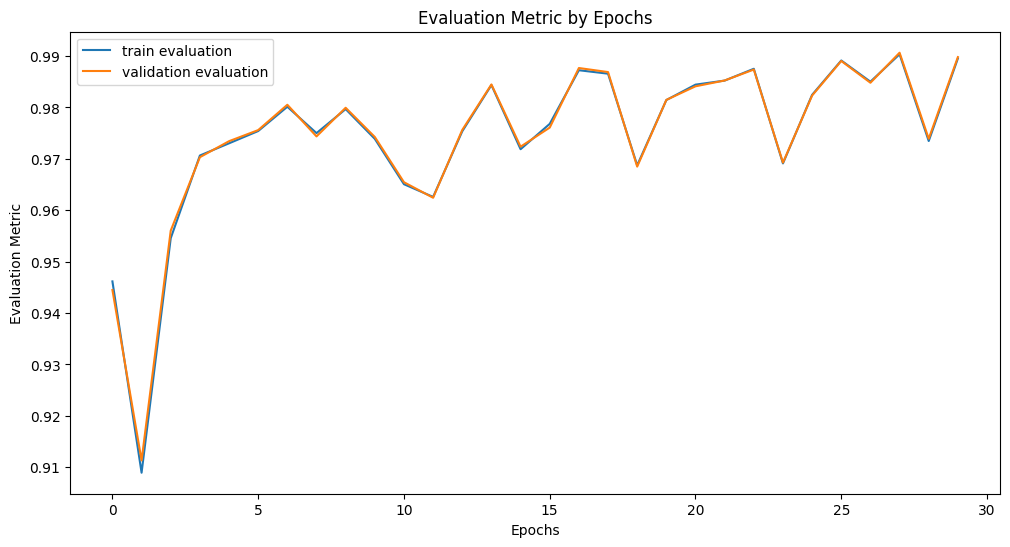

In [6]:
# split data
train_dataloader, val_dataset, test_dataset = utils.prepare_data(df_BSD_balanced, 'sha', device, if_regression=True)
# train the model
model, train_eval_hist, val_eval_hist, train_loss_hist, val_loss_hist = executor.train(model, train_dataloader, val_dataset, loss_func, evaluator, optimizer, num_epochs, if_regression=True, verbose=True)
# plot train_eval_hist, val_eval_hist
utils.plot_train_eval_hist(train_eval_hist, val_eval_hist)

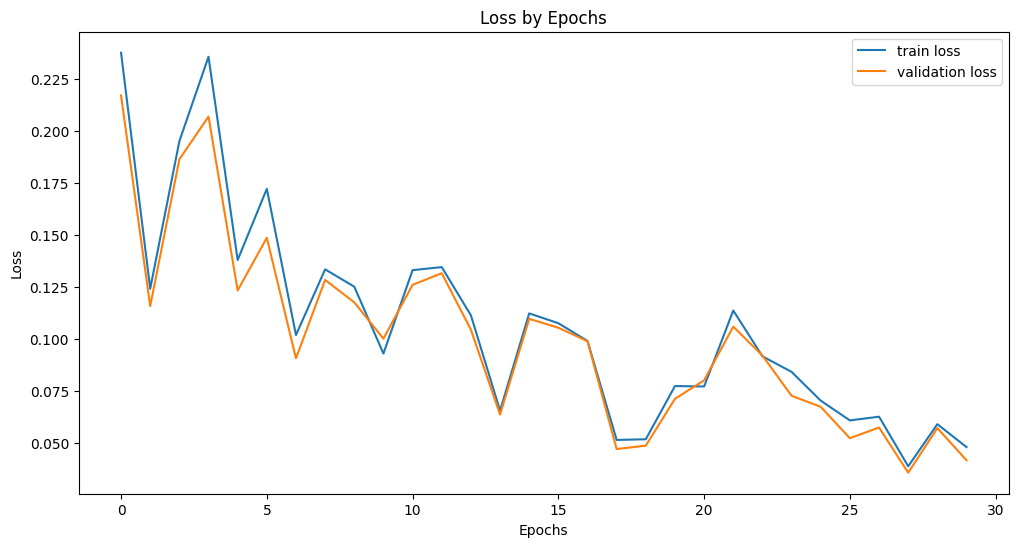

In [7]:
utils.plot_train_loss_hist(train_loss_hist, val_loss_hist)

In [8]:
acc = executor.test(model, test_dataset, evaluator, if_regression = True)
mae = executor.test(model, test_dataset, mean_absolute_error, if_regression = True)
mse = executor.test(model, test_dataset, mean_squared_error, if_regression = True)
print(f"Test accuracy: {acc:0.4f}")
print(f"Test Mean Absolute Error: {mae:0.4f}. Test Mean Squared Error: {mse:0.4f}")

Test accuracy: 0.9900
Test Mean Absolute Error: 0.1193. Test Mean Squared Error: 0.8387
